# Analysis of the chains

here I am mainly concerned with plotting H0 distributions.

### matplotlib settings and test run (suppressed)

In [2]:
from getdist import MCSamples, plots
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os

#plt.style.use("ggplot")        # if you want a more distinct style
plt.style.use("seaborn-v0_8-pastel")
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
# Load the damn data
data = np.loadtxt("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000__1.txt")

# Get param names  
with open("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000_.paramnames") as f:
    paramnames = [line.split()[0] for line in f]

# Skip first 2 columns, take only parameter columns
params = data[:, 2:2+len(paramnames)]

# Replace underscores in labels to avoid LaTeX parsing
clean_labels = [name.replace('_', ' ') for name in paramnames]

# Create samples with clean labels
samples = MCSamples(samples=params, names=paramnames, labels=clean_labels)

# Force no LaTeX
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples], filled=True)

#plt.show()

Removed no burn in


### Functions: load chains and plot H0 posteriors

Found 4 chain files
Loaded 2025-12-19_1000000__2.txt: 515 samples
Loaded 2025-12-19_1000000__3.txt: 510 samples
Loaded 2025-12-19_1000000__1.txt: 490 samples
Loaded 2025-12-19_1000000__4.txt: 470 samples


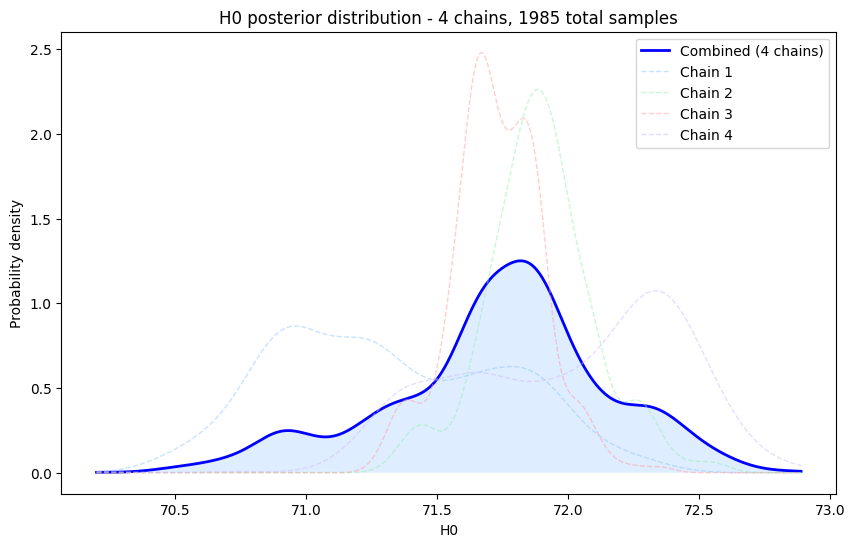

Combined H0: 71.73 ± 0.42
Total samples: 1985
Number of chains: 4


In [7]:

def load_chains(chain_pattern):
    """Load multiple chains, filtering out malformed/empty ones"""
    all_h0 = []
    
    # Find all matching chain files
    chain_files = glob.glob(chain_pattern)
    print(f"Found {len(chain_files)} chain files")
    
    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            
            # Skip if file is empty or too short
            if len(data) < 100:  # Minimum 100 samples
                print(f"Skipping {os.path.basename(chain_file)}: too short ({len(data)} samples)")
                continue
                
            # Get H0 values (3rd column, index 2)
            h0_values = data[:, 2]
            
            # Skip if H0 values are nonsense (outside reasonable range)
            if np.any(h0_values < 50) or np.any(h0_values > 100):
                print(f"Skipping {os.path.basename(chain_file)}: H0 values out of reasonable range")
                continue
                
            all_h0.append(h0_values)
            print(f"Loaded {os.path.basename(chain_file)}: {len(h0_values)} samples")
            
        except Exception as e:
            print(f"Failed to load {os.path.basename(chain_file)}: {e}")
            continue
    
    return all_h0

# Load all valid chains
chain_pattern = "/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp/9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19/2025-12-19_1000000__*.txt"
all_h0_chains = load_chains(chain_pattern)

if not all_h0_chains:
    print("No valid chains found!")
else:
    # Combine all chains
    combined_h0 = np.concatenate(all_h0_chains)
    
    # Create KDE for smooth distribution
    kde = stats.gaussian_kde(combined_h0)
    x_vals = np.linspace(combined_h0.min(), combined_h0.max(), 1000)
    y_vals = kde(x_vals)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, 'b-', linewidth=2, label=f'Combined ({len(all_h0_chains)} chains)')
    plt.fill_between(x_vals, y_vals, alpha=0.3)
    
    # Also plot individual chains if you want to see them
    for i, h0_chain in enumerate(all_h0_chains):
        if len(h0_chain) > 100:  # Only plot if reasonably sized
            kde_individual = stats.gaussian_kde(h0_chain)
            y_individual = kde_individual(x_vals)
            plt.plot(x_vals, y_individual, '--', alpha=0.5, linewidth=1, label=f'Chain {i+1}')
    
    plt.xlabel('H0')
    plt.ylabel('Probability density')
    plt.title(f'H0 posterior distribution - {len(all_h0_chains)} chains, {len(combined_h0)} total samples')
    plt.legend()
    plt.show()
    
    # Calculate combined statistics
    mean = np.mean(combined_h0)
    std = np.std(combined_h0)
    print(f"Combined H0: {mean:.2f} ± {std:.2f}")
    print(f"Total samples: {len(combined_h0)}")
    print(f"Number of chains: {len(all_h0_chains)}")

In [8]:
from pathlib import Path

def load_chains_from_folder(folder_path):
    """Load all valid chains from a folder"""
    all_h0 = []
    

    # patterns_priority = [
    #     "*2000000__*.txt",
    #     "*1010000__*.txt",
    # ]

    # # collect higher-priority files
    # chain_files = []
    # for pattern in patterns_priority:
    #     chain_files.extend(glob.glob(str(folder_path / pattern)))

    # # fallback if none found
    # if not chain_files:
    chain_files = glob.glob(str(folder_path / "*__*.txt"))
    for chain_file in chain_files:
        try:
            data = np.loadtxt(chain_file)
            
            # Skip if file is empty or too short
            if len(data) < 100:
                continue
                
            # Get H0 values (3rd column, index 2)
            h0_values = data[:, 2]
            
            # Skip if H0 values are nonsense
            if np.any(h0_values < 50) or np.any(h0_values > 100):
                continue
                
            all_h0.append(h0_values)
            
        except Exception as e:
            continue
    
    if all_h0:
        return np.concatenate(all_h0)
    else:
        return None

def plot_axion_group(chain_names, group_name, base_path):
    """Plot H0 distributions for a group of chains"""
    plt.figure(figsize=(12, 8))
    
    # Colors for different lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(chain_names)))
    
    for i, chain_folder in enumerate(chain_names):
        folder_path = base_path / chain_folder
        print(f"Processing {chain_folder}...")
        
        if not folder_path.exists():
            print(f"  Folder does not exist: {folder_path}")
            continue
            
        h0_data = load_chains_from_folder(folder_path)
        
        if h0_data is not None and len(h0_data) > 0:
            # Create KDE
            kde = stats.gaussian_kde(h0_data)
            x_vals = np.linspace(60, 80, 1000)
            y_vals = kde(x_vals)
            
            # Clean up the label
            label = chain_folder.replace(f'{group_name}_', '').replace('planck_TTTEEElensing_', '')
            
            plt.plot(x_vals, y_vals, color=colors[i], linewidth=2, label=label)
            
            # Calculate statistics
            mean = np.mean(h0_data)
            std = np.std(h0_data)
            print(f"  {label}: H0 = {mean:.2f} ± {std:.2f} (n={len(h0_data)})")
    
    plt.xlim(65,75)
    plt.xlabel('H0', fontsize=14)
    plt.ylabel('Probability density', fontsize=14)
    plt.title(f'H0 posterior distributions - {group_name}', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Base path
base = Path("/Users/bellamarco01/uni/1_master_thesis/montepython_chains/chains_mp")

# Define your groups
names_1_ax = [
    "1_ax_planck_TTTEEElensing2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
]

names_1_boss_vs_desi = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_boss2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_boss2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
] 

names_4_ax = [
    "4_ax_planck_TTTEEElensing_pantheon_plus2025-11-12",
    "4_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-12",
]

names_9_ax = [
    "planck_TTTEEElensing_mAxi_shooting2025-11-14",
    "9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
]

names_9_boss_vs_desi = [
    "9_axions/planck_TTTEEElensing_pantheon_plus_boss_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_boss_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
]
# Plot each group
#plot_axion_group(names_1_ax, "1 Axion", base)
#plot_axion_group(names_4_ax, "4 Axions", base)
#plot_axion_group(names_9_ax, "9 Axions", base)
#plot_axion_group(names_0_ax, "0 Axions (Baseline)", base)

## Here we compare 1 vs 9 axions for each given dataset. 
for the H0 posterior

Processing 1_ax_planck_TTTEEElensing2025-11-21...
  1_ax_planck_TTTEEElensing2025-11-21: H0 = 67.83 ± 1.10 (n=84865)
Processing planck_TTTEEElensing_mAxi_shooting2025-11-14...
  mAxi_shooting2025-11-14: H0 = 74.24 ± 1.90 (n=83795)


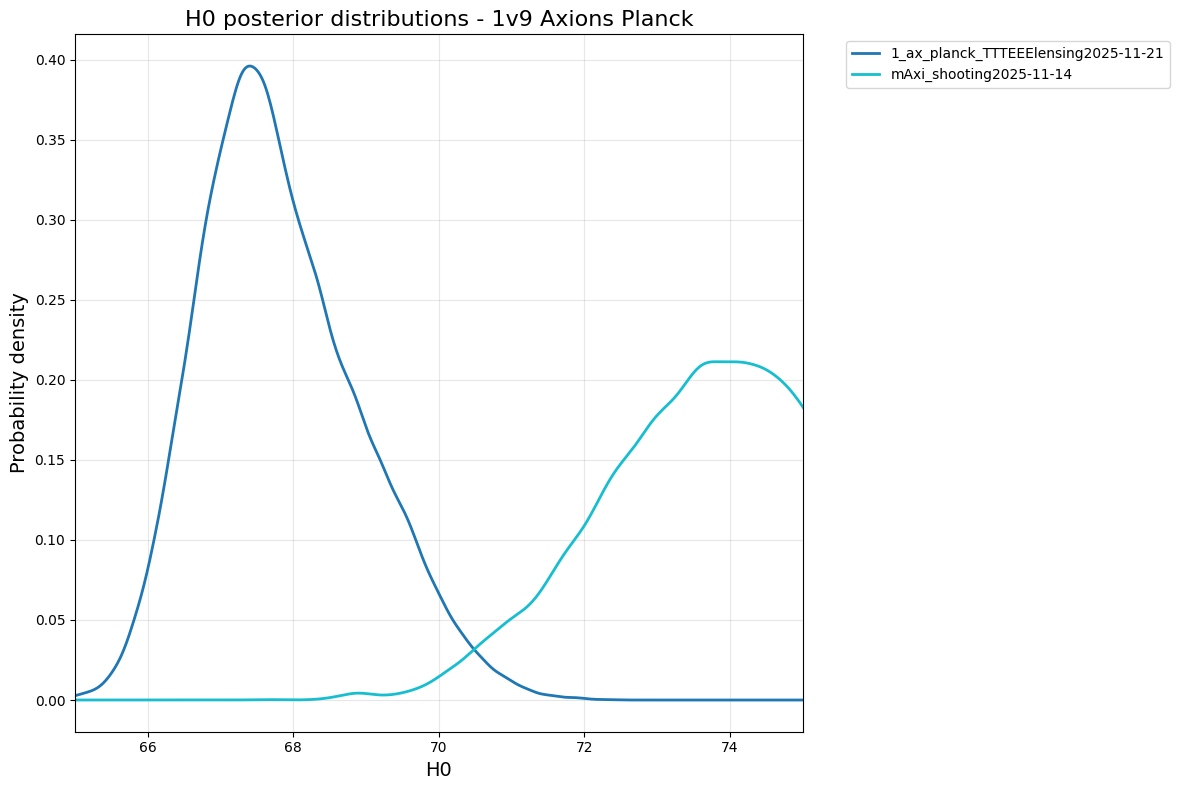

Processing 1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21...
  1_ax_pantheon_plus2025-11-21: H0 = 67.76 ± 0.95 (n=47680)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19...
  9_axions/pantheon_plus_2025-12-19: H0 = 71.73 ± 0.42 (n=1985)


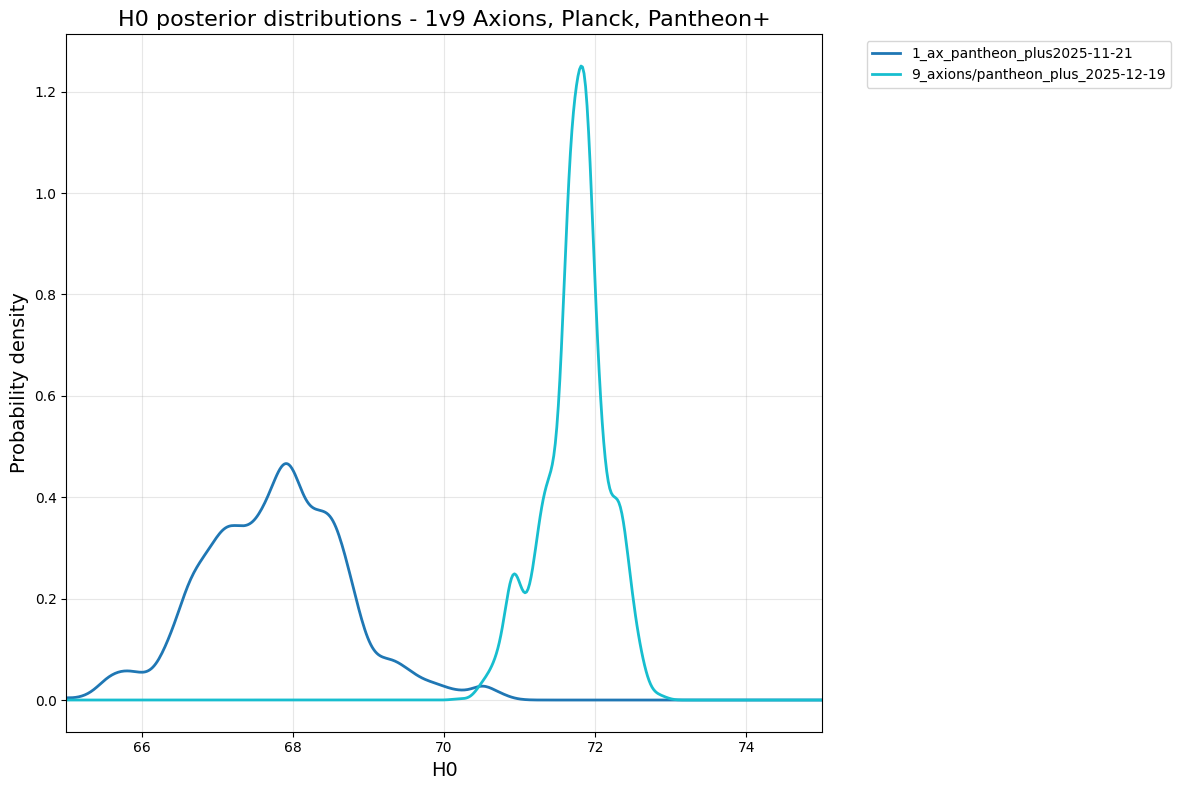

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21...
  1_ax_pantheon_plus_sh0es2025-11-21: H0 = 70.99 ± 1.14 (n=36730)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19...
  9_axions/pantheon_plus_sh0es_2025-12-19: H0 = 72.61 ± 0.62 (n=2075)


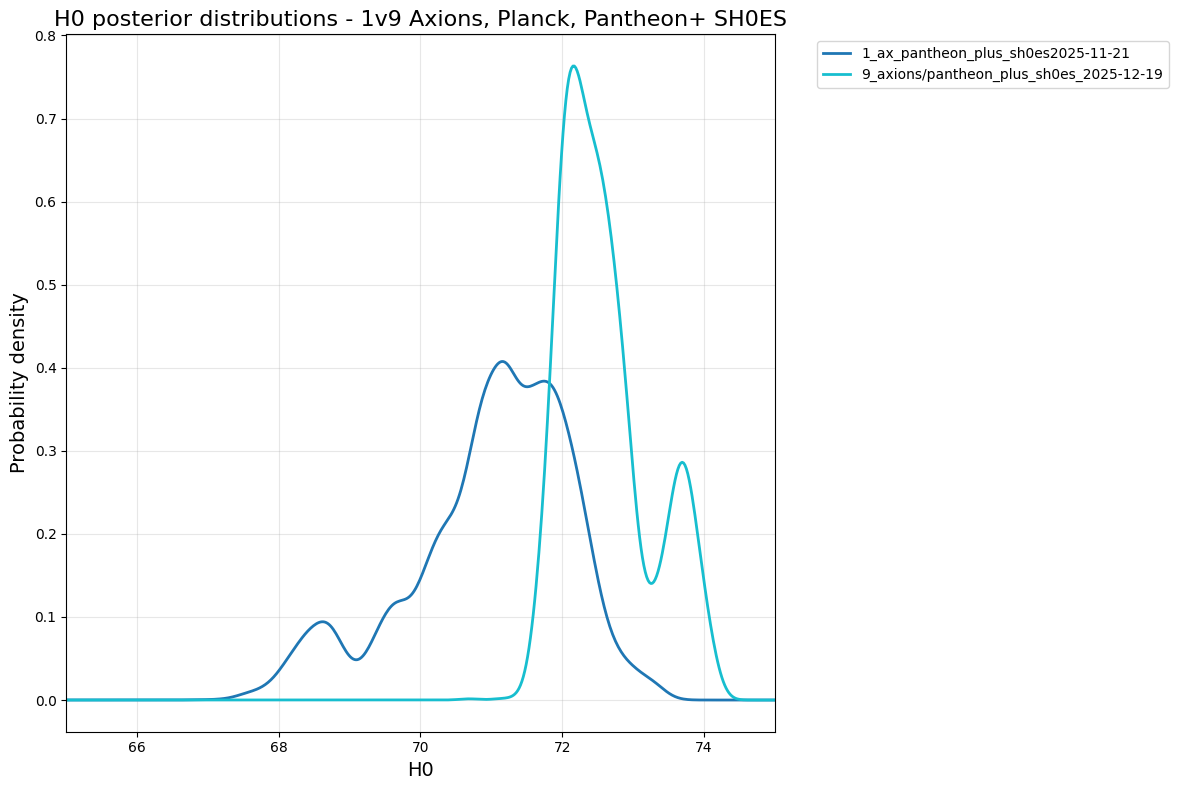

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21...
  1_ax_pantheon_plus_desi2025-11-21: H0 = 69.12 ± 0.79 (n=50065)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19...
  9_axions/pantheon_plus_desi_2025-12-19: H0 = 72.14 ± 0.28 (n=1835)


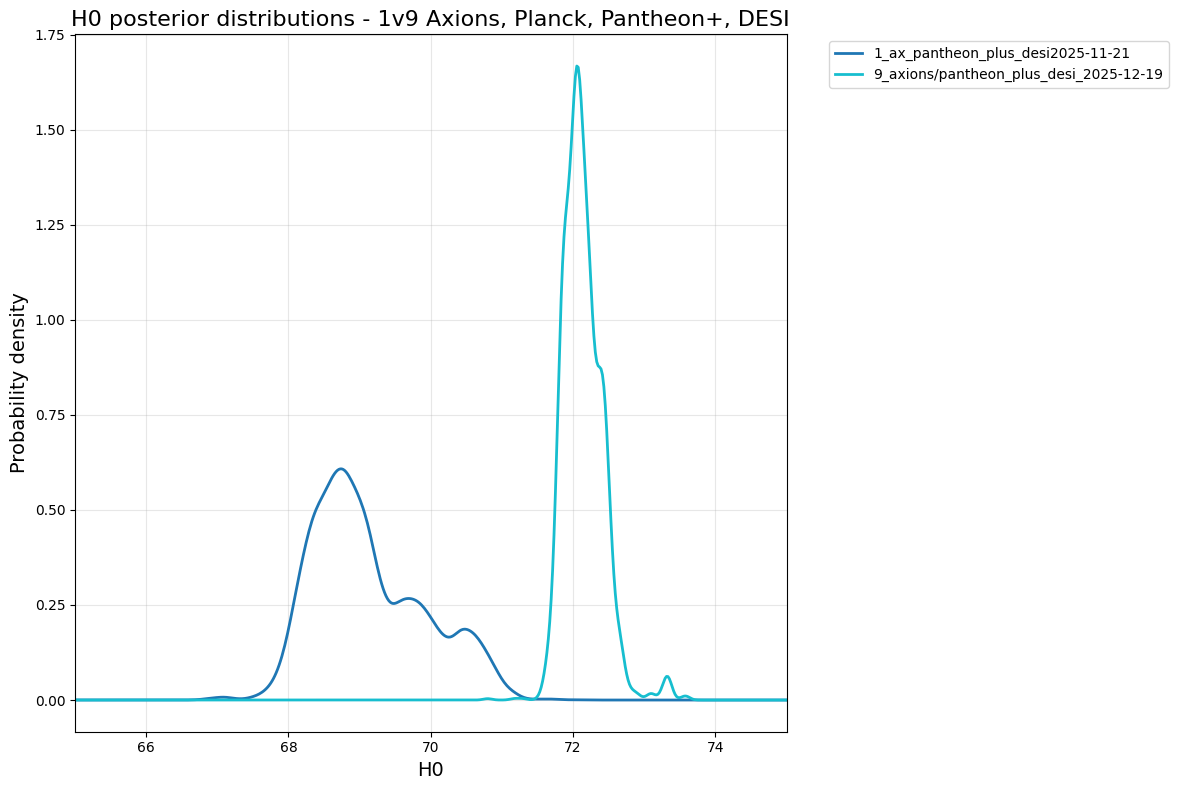

Processing 1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21...
  1_ax_pantheon_plus_sh0es_desi2025-11-21: H0 = 71.29 ± 1.12 (n=39665)
Processing 9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19...
  9_axions/pantheon_plus_sh0es_desi_2025-12-19: H0 = 72.42 ± 0.54 (n=1815)


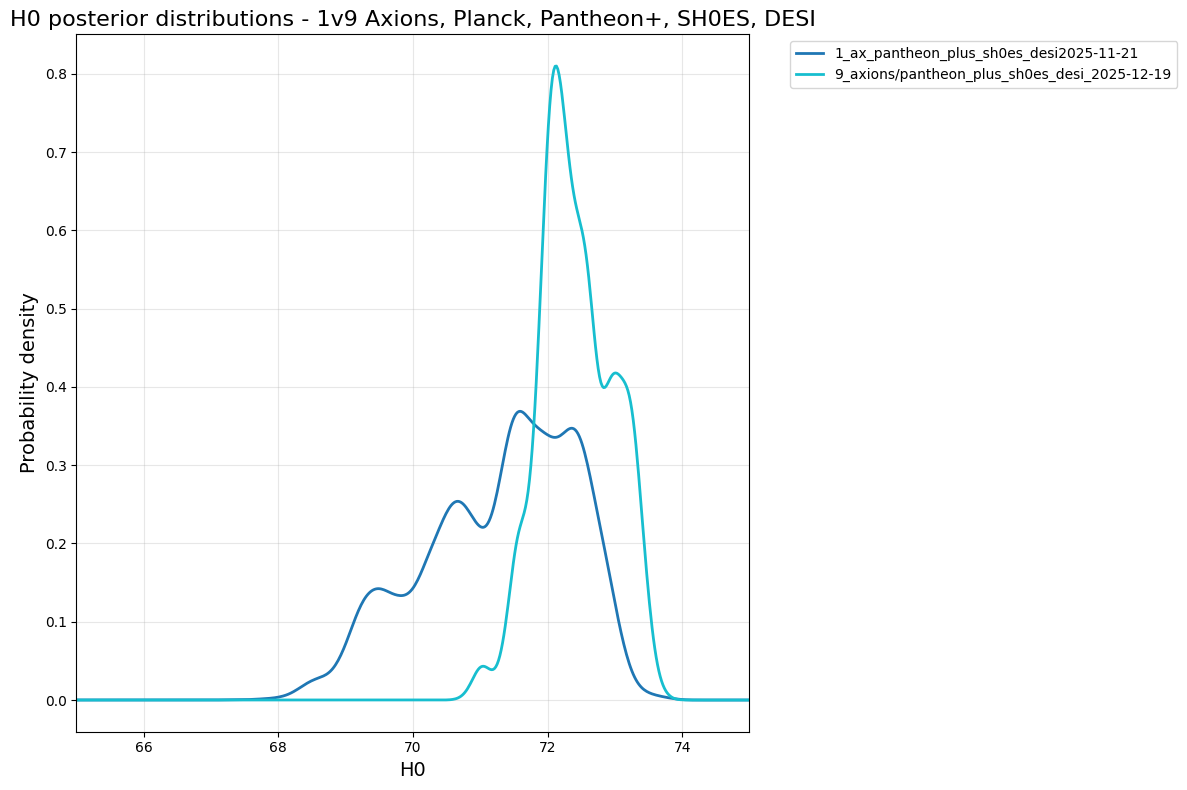

In [17]:

# Define your groups
planck_1_vs_9 = [
    "1_ax_planck_TTTEEElensing2025-11-21",
    "planck_TTTEEElensing_mAxi_shooting2025-11-14",
    ]

pantheon_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_2025-12-19",
    ]

pantheon_sh0es_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_2025-12-19",
    ]
pantheon_desi_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_desi2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_desi_2025-12-19",
    ]
pantheon_sh0es_desi_1_vs_9 = [
    "1_ax_planck_TTTEEElensing_pantheon_plus_sh0es_desi2025-11-21",
    "9_axions/planck_TTTEEElensing_pantheon_plus_sh0es_desi_2025-12-19",
    ]
# Plot each group
plot_axion_group(planck_1_vs_9, "1v9 Axions Planck", base)
plot_axion_group(pantheon_1_vs_9, "1v9 Axions, Planck, Pantheon+", base)
plot_axion_group(pantheon_sh0es_1_vs_9, "1v9 Axions, Planck, Pantheon+ SH0ES", base)
plot_axion_group(pantheon_desi_1_vs_9, "1v9 Axions, Planck, Pantheon+, DESI", base)
plot_axion_group(pantheon_sh0es_desi_1_vs_9, "1v9 Axions, Planck, Pantheon+, SH0ES, DESI", base)
#plot_axion_group(names_0_ax, "0 Axions (Baseline)", base)

Processing 4_ax_planck_TTTEEElensing_pantheon_plus2025-11-12...
  4_ax_pantheon_plus2025-11-12: H0 = 68.25 ± 0.86 (n=39595)
Processing 4_ax_planck_TTTEEElensing_pantheon_plus_sh0es2025-11-12...
  4_ax_pantheon_plus_sh0es2025-11-12: H0 = 70.73 ± 1.59 (n=47240)


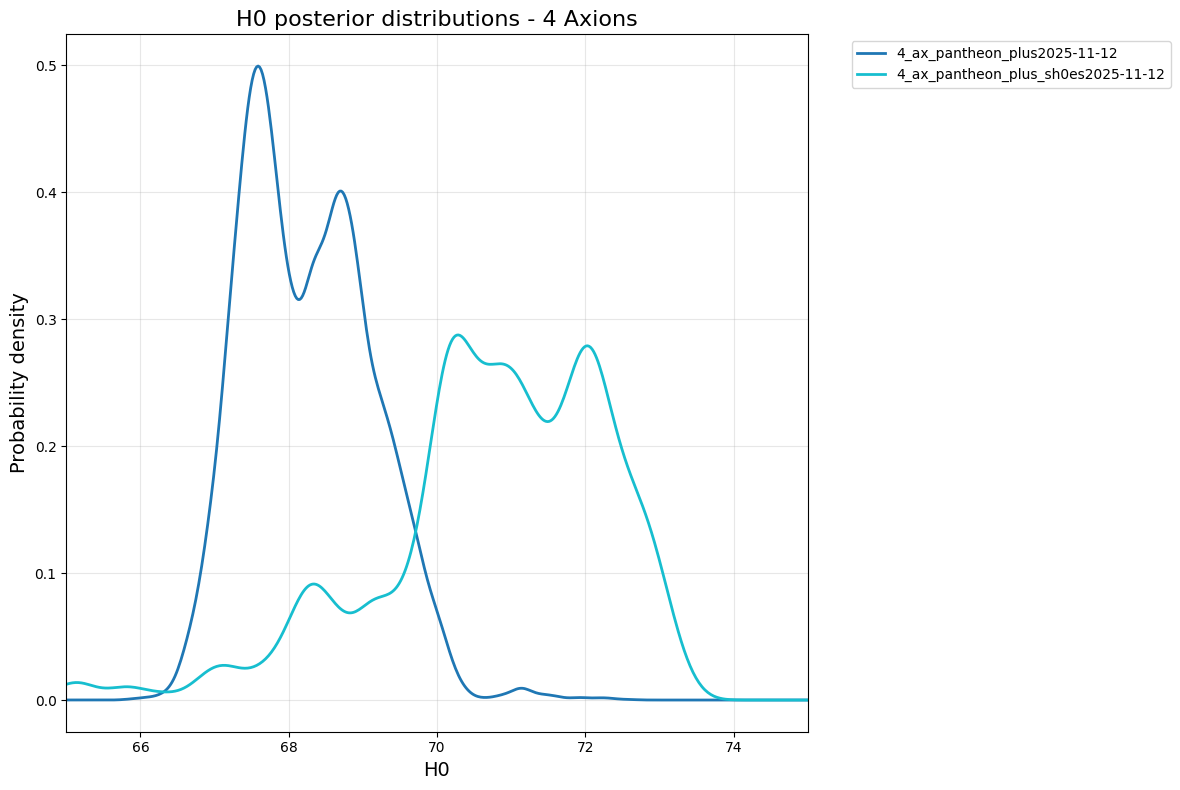

In [6]:

plot_axion_group(names_4_ax, "4 Axions", base)